In [43]:
from __future__ import annotations
from data_generation import process_matrix
import matplotlib.pyplot as plt
from typing import Optional
from model import CNNModel
import seaborn as sns
import numpy as np
import random
import torch

In [57]:
matrix = np.array([
    [1, 6, 9],
    [4, 3, 5],
    [8, 1, 10]
])

model_row_accuracy = np.array([1 for _ in range(12)])

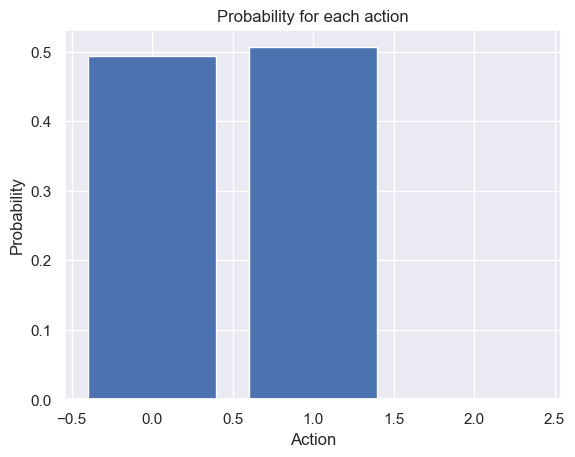

In [58]:
T = 2 # Temperature

def row_probability(row_value: np.ndarray, model_prediction: np.ndarray, model_accuracy: float) -> list[float]:
    def model_probability(value: float, prediction: float, accuracy: float) -> float:
        return value if prediction == 0 else value * (1 - accuracy)
    
    model_values = [model_probability(value, prediction, model_accuracy) for value, prediction in zip(row_value, model_prediction)]
    total_model_values = sum(model_values)

    subtract_values = [total_model_values - value for value in model_values]
    total_subtract_values = sum(subtract_values)
    if total_subtract_values == 0:
        return [1 / len(model_values) for _ in model_values]
    probs = [(total_model_values - value)**T / total_subtract_values for value in model_values]
    return [prob / sum(probs) for prob in probs]

row_index = 0
probs = row_probability(matrix[row_index], np.array([1, 1, 0]), model_row_accuracy[row_index])

actions = {
    i: 0 for i in range(len(probs))
}
for _ in range(10000):
    action = random.choices(range(len(probs)), probs)[0]
    actions[action] += 1

sns.set_theme()
plt.bar(
    list(actions.keys()),
    [actions[key] / sum(actions.values()) for key in actions],
)
plt.xlabel('Action')
plt.ylabel('Probability')
plt.title('Probability for each action')
plt.show()


In [59]:
def augmented_matrix(matrix: np.ndarray, new_size: int, g1_size: int, g2_size: int) -> np.ndarray:
    if matrix.shape[0] > new_size or matrix.shape[1] > new_size:
        raise ValueError("New size is smaller than the original matrix")
    n = g1_size
    m = g2_size
    new_matrix = np.zeros((new_size, new_size))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    for i in range(new_size):
        for j in range(new_size):
            if i < n and j >= matrix.shape[0]:
                to_replace = matrix[i, -1]
                new_matrix[i, j] = to_replace
            elif i >= matrix.shape[1] and j < m:
                to_replace = matrix[-1, j]
                new_matrix[i, j] = to_replace

    return new_matrix

In [60]:
# Load the model
MATRIX_SIZE = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(
    state_size=MATRIX_SIZE**2,
    input_size=2,
    num_hidden=64
).to(device)

model.load_state_dict(torch.load("models/cnn_model_12.pth"))

<All keys matched successfully>

In [64]:
def get_mcts_cost(matrix: np.ndarray, config: dict, max_depth: int, max_iterations: int, model) -> tuple[np.ndarray, float]:
    """Return the best actions and the cost of the best actions using MCTS."""
    state = np.stack([matrix, np.ones(matrix.shape),
                     np.zeros(matrix.shape)], axis=0)

    root = Node(state, config)
    mcts = MCTS(root, config, max_depth, max_iterations, model)
    return mcts.search()


def get_untried_actions(state: np.ndarray, depth: int) -> list[int]:
    """Return a list of untried actions."""
    if depth >= state[1].shape[0]:
        return []
    return np.argwhere(state[1][depth] == 1).flatten().tolist()


class Node:

    def __init__(self, state: np.ndarray, config: dict, parent=None, action=None, depth=0):
        self.state = state
        self.config = config
        self.parent = parent
        self.action = action
        self.depth = depth

        self.children: list[Node] = []

        self.visit_count = 0
        self.value = 0

    def is_expanded(self) -> bool:
        """Returns True if the node has children."""
        return len(self.children) > 0

    def select(self) -> Optional[Node]:
        """Return the child with the highest UCB score."""
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child: Node) -> float:
        """Return the UCB score of a child node."""
        if child.visit_count == 0:
            return np.inf
        exploitation = child.value / child.visit_count
        exploration = self.config["exploration_constant"] * \
            np.sqrt(np.log(self.visit_count) / child.visit_count)

        return exploitation + exploration

    def expand(self) -> None:
        """Expand the node by creating all possible children."""
        child = None
        for action in get_untried_actions(self.state, self.depth):
            new_state = self.state.copy()
            new_state[1][self.depth] = 0
            new_state[1][:, action] = 0
            new_state[2][self.depth][action] = 1

            child = Node(new_state, self.config, self, action, self.depth + 1)
            self.children.append(child)

    def backpropagate(self) -> None:
        """Update the node's value and visit count."""
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate()


class MCTS:

    def __init__(self, root: Node, config: dict, max_depth: int, max_iterations: int = 1000, model=None):
        self.root = root
        self.config = config
        self.max_depth = max_depth
        self.max_iterations = max_iterations
        self.best_value = np.inf
        self.best_actions = []
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def search(self) -> tuple[np.ndarray, float]:
        for _ in range(self.max_iterations):
            node = self.select_node()
            actions, value = self.rollout(node)
            if value < self.best_value:
                self.best_value = value
                self.best_actions = actions
            node.backpropagate()

        # reverse the actions to get the best actions from the root

        return self.best_actions, self.best_value

    def select_node(self) -> Node:
        """Select a node to expand."""
        node = self.root
        while node.is_expanded():
            node = node.select()
            if node is None:
                raise ValueError("Selecting a childless node.")
        if not node.is_expanded():
            node.expand()
        return node

    def rollout(self, node: Node) -> tuple[np.ndarray, float]:
        """Simulate a game from the given node."""
        state = node.state.copy()
        depth = node.depth
        actions_taken = np.zeros(state[0].shape)
        while depth < self.max_depth:
            actions = get_untried_actions(state, depth)
            if len(actions) == 1:
                action = actions[0]
            elif self.config["rollout_mode"] == "random":
                action = random.choice(actions)
            else:
                model_matrix = process_matrix(state[0], state[0].shape[0])
                model_state = np.stack([model_matrix, state[2].astype(np.int32)], axis=0)
                model_state = torch.tensor(model_state, dtype=torch.float32).unsqueeze(0).to(self.device)
                model_value = model(model_state)
                print(model_value)
                probability = row_probability(
                    state[0][depth], np.array([1 for _ in range(12)]), model_row_accuracy[depth]
                )
                available_probs = [probability[i] for i in actions]
                normalized_probs = [
                    prob / sum(available_probs) for prob in available_probs
                ]
                action = random.choices(actions, normalized_probs)[0]
                

            state[1][depth] = 0
            state[1][:, action] = 0
            state[2][depth][action] = 1
            actions_taken = state[2]
            depth += 1
        return actions_taken, self.evaluate(state)

    def evaluate(self, state: np.ndarray) -> float:
        """Evaluate the given state."""
        return np.multiply(state[0], state[2]).sum()

In [65]:
matrix = augmented_matrix(matrix, 12, 3, 3)
print(matrix)
get_mcts_cost(matrix, {'exploration_constant': 1, 'rollout_mode': 'other'}, 12, 1, model)

[[ 1.  6.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [ 4.  3.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 8.  1. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
tensor([[-0.1430,  1.1220]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2652,  1.2428]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0122, 0.9703]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2278,  1.2059]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0856, 0.8899]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.6773, 0.2954]], devi

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 7.0)